# Análise das empresas taiwanesas
[LINK](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction?resource=download)

Os dados consistem em métricas financeiras de empresas listadas na Bolsa de Valores de Taiwan. O objetivo é usar essas métricas para prever a probabilidade de uma empresa falir em um futuro próximo.

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import lightgbm
from sklearn import preprocessing, metrics, pipeline, model_selection
from scipy.cluster import hierarchy as sch

%matplotlib inline
sns.set(style="ticks", palette="colorblind", rc={"figure.figsize": (11.7, 8.27)})

/Users/fabiogavarinibaccarin/.local/share/virtualenvs/colinearidade-OMZFyDA9/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dados

In [2]:
df = pd.read_csv("data.csv")
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [3]:
# renomeando para facilitar o código
NAMES = {c: "y" if c == "Bankrupt?" else f"x{i:02d}" for i, c in enumerate(df.columns)}
NAMES

{'Bankrupt?': 'y',
 ' ROA(C) before interest and depreciation before interest': 'x01',
 ' ROA(A) before interest and % after tax': 'x02',
 ' ROA(B) before interest and depreciation after tax': 'x03',
 ' Operating Gross Margin': 'x04',
 ' Realized Sales Gross Margin': 'x05',
 ' Operating Profit Rate': 'x06',
 ' Pre-tax net Interest Rate': 'x07',
 ' After-tax net Interest Rate': 'x08',
 ' Non-industry income and expenditure/revenue': 'x09',
 ' Continuous interest rate (after tax)': 'x10',
 ' Operating Expense Rate': 'x11',
 ' Research and development expense rate': 'x12',
 ' Cash flow rate': 'x13',
 ' Interest-bearing debt interest rate': 'x14',
 ' Tax rate (A)': 'x15',
 ' Net Value Per Share (B)': 'x16',
 ' Net Value Per Share (A)': 'x17',
 ' Net Value Per Share (C)': 'x18',
 ' Persistent EPS in the Last Four Seasons': 'x19',
 ' Cash Flow Per Share': 'x20',
 ' Revenue Per Share (Yuan ¥)': 'x21',
 ' Operating Profit Per Share (Yuan ¥)': 'x22',
 ' Per Share Net profit before tax (Yuan ¥)'

In [4]:
NAMES_KEYS = list(NAMES.keys())
NAMES_VALS = list(NAMES.values())

def get_original_name(code):
    return NAMES_KEYS[NAMES_VALS.index(code)]

In [5]:
df = df.rename(columns=NAMES)
df.head(3)

,y,x01,x02,x03,x04,x05,x06,x07,x08,x09,...,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474


## Análise exploratória

In [6]:
# nulos
df.isna().mean().to_frame().T.style.format("{:.2%}")

,y,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [7]:
# testando que não tem absolutamente nenhum nulo
assert df.isna().sum().sum() == 0

In [8]:
# verificando que todas as variáveis são contínuas
df.nunique().to_frame().T.style.format("{:,}")

,y,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95
0,2,"3,333","3,151","3,160","3,781","3,788","3,376","3,789","3,604","2,551","3,617","2,966","1,536","5,557","1,080","2,488","2,278","2,285","2,284","1,358","1,545","3,807","1,236","1,522","5,583","6,249","6,246","6,253","6,270","1,751","4,502","2,903","3,599","6,132","6,094","3,794","5,518","4,208","4,208","6,523","4,338","1,855","4,423","4,785","5,289",381,"1,593","5,451","2,397","2,451",741,"5,667","3,023","6,768","6,819","6,819","6,819","6,819","6,819","6,816","6,819","6,819","6,593","6,590","6,627","6,819","6,819","4,249","6,819","6,819","6,819","6,261","5,377","6,819","4,023","6,819","6,814","6,627","6,819","4,251","6,819","6,819","6,819","6,819","6,819",2,"6,819","6,818","6,819","6,816","6,819","6,819","6,240","6,240",1,"6,819"


In [9]:
print(get_original_name("x85"))
print(get_original_name("x94"))

 Liability-Assets Flag
 Net Income Flag


In [10]:
"x85 prevalence={:.2%}".format(df["x85"].mean())

'x85 prevalence=0.12%'

In [11]:
# removendo x85 e x94
df = df.drop(columns=["x85", "x94"])

# provando que todas as variáveis são contínuas
assert df.drop(columns="y").nunique().min() > 40

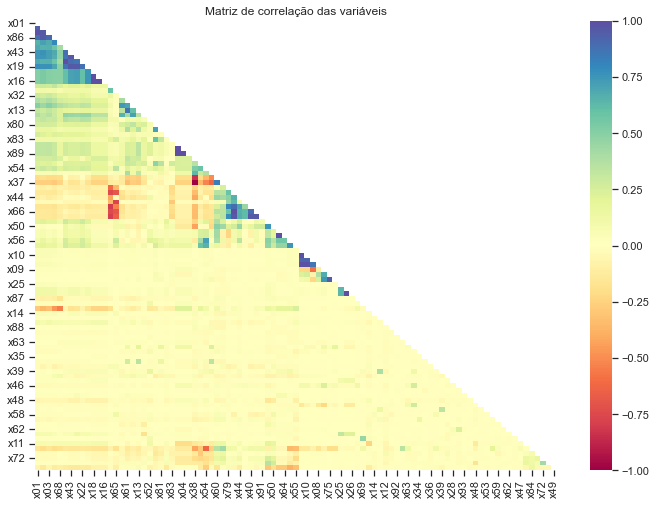

In [12]:
# correlação entre as variáveis
corr = df.drop(columns="y").corr()

# faz um clustering hierárquico, agrupando as variáveis mais correlacionadas
# fonte: https://wil.yegelwel.com/cluster-correlation-matrix/
pairwise_distances = sch.distance.pdist(corr)
linkage = sch.linkage(pairwise_distances, method="ward")
cluster_distance_threshold = pairwise_distances.max()/2
idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, criterion="distance")
idx = np.argsort(idx_to_cluster_array)

sns.heatmap(
    corr.iloc[idx, :].T.iloc[idx, :],
    cmap="Spectral",
    mask=np.triu(np.ones(corr.shape)).astype(bool)
).set(title="Matriz de correlação das variáveis");

## Modelagem

In [13]:
X = df.drop(columns="y")
y = df["y"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5455, 93) (5455,)
(1364, 93) (1364,)


In [14]:
preprocessor = pipeline.make_pipeline(
    preprocessing.QuantileTransformer(output_distribution="normal", random_state=0),
    preprocessing.MaxAbsScaler(),
)

### Usando todas as variáveis

In [15]:
lgbc_full = pipeline.make_pipeline(
    preprocessor,
    lightgbm.LGBMClassifier(random_state=0)
).fit(X_train, y_train)

probs_full = pd.Series(lgbc_full.predict_proba(X_test)[:, 1], index=X_test.index, name="probs_full")
roc_full = metrics.roc_auc_score(y_test, probs_full)
f"ROC FULL={roc_full:.0%}"

'ROC FULL=95%'